In [12]:
from pyspark.sql.session import SparkSession
from pyspark.sql import functions as fn

import matplotlib.pyplot as plt

In [19]:
spark = SparkSession.builder.appName("Analysis").getOrCreate()

In [10]:
# Reading dataset

vehicles_df = spark.read.csv("hdfs://localhost:9000/mnt/data/source/vehicles.csv", inferSchema=True, header=True)

AnalysisException: 'Path does not exist: hdfs://localhost:9000/mnt/data/source/vehicles.csv;'

In [4]:
# Dropping unused columns

vehicles_df = vehicles_df.drop("_c0")

In [13]:
vehicles_df.columns

[',id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date']

## Task-7 Querying Using Spark SQL

In [6]:
vehicles_df.createOrReplaceTempView("vehicles")

In [11]:
spark.sql("SELECT * FROM VEHICLES LIMIT 10").toPandas().head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,...,rwd,None,other,None,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.59,-85.48,2020-12-02T08:11:30-0600
1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,...,fwd,None,sedan,None,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.5475,-85.4682,2020-12-02T02:11:50-0600
2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,...,None,None,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600
3,7240103965,https://auburn.craigslist.org/cto/d/lanett-tru...,auburn,https://auburn.craigslist.org,2000,1974.0,chevrolet,c-10,good,4 cylinders,...,rwd,full-size,pickup,blue,https://images.craigslist.org/00M0M_6o7KcDpArw...,1974 chev. truck (LONG BED) NEW starter front ...,al,32.8616,-85.2161,2020-12-01T15:54:45-0600
4,7239983776,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,19500,2005.0,ford,f350 lariat,excellent,8 cylinders,...,4wd,full-size,pickup,blue,https://images.craigslist.org/00p0p_b95l1EgUfl...,2005 Ford F350 Lariat (Bullet Proofed). This t...,al,32.5475,-85.4682,2020-12-01T12:53:56-0600


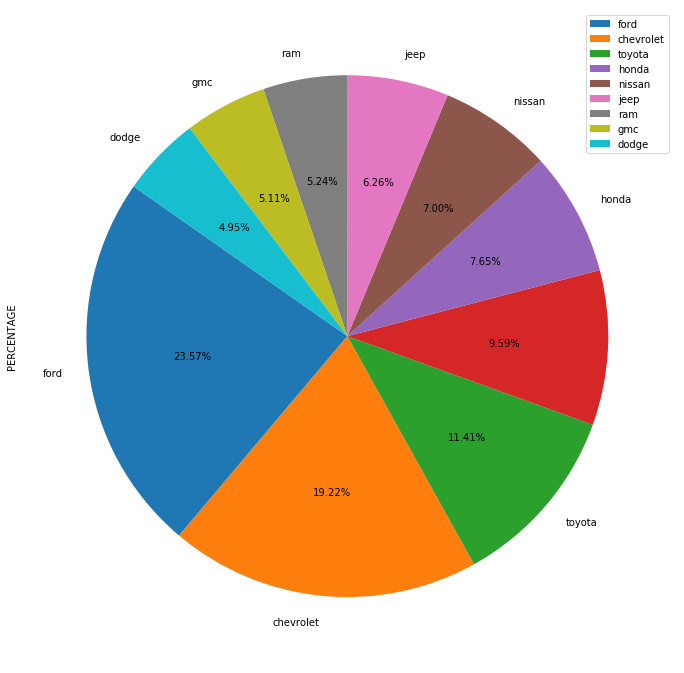

In [20]:
# Analysis-1

pd_df = spark.sql("SELECT MANUFACTURER, 100*(COUNT(1)/(SELECT COUNT(1) FROM VEHICLES)) AS PERCENTAGE \
                    FROM VEHICLES \
                    GROUP BY MANUFACTURER \
                    ORDER BY PERCENTAGE DESC \
                    LIMIT 10").toPandas()

pd_df.plot.pie(y="PERCENTAGE", labels=pd_df["MANUFACTURER"], figsize=(12,12), startangle=145, autopct='%.2f%%')

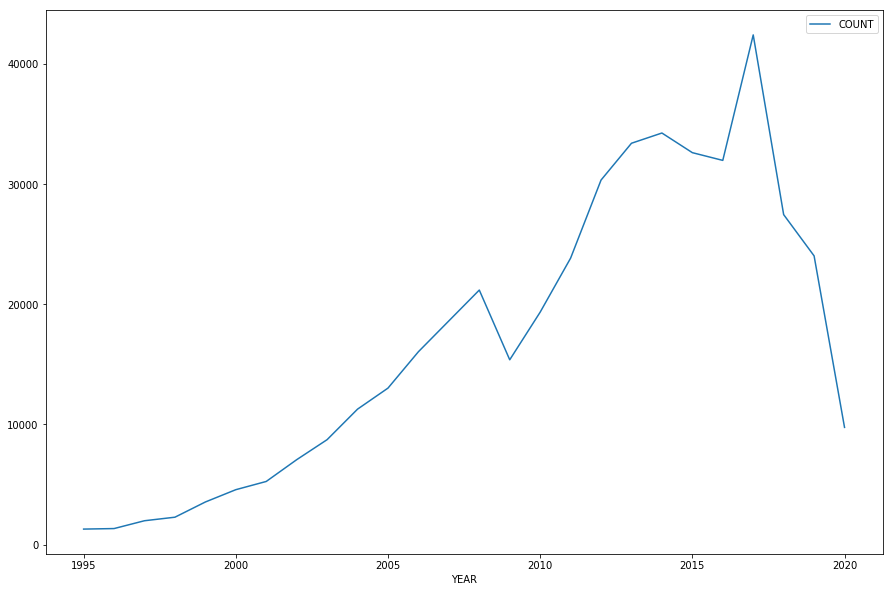

In [32]:
# Analysis-2

spark.sql("DROP TABLE IF EXISTS VEHICLES_STG")

spark.sql("CREATE TABLE VEHICLES_STG AS \
            SELECT CAST(YEAR AS INTEGER) YEAR \
            FROM VEHICLES")

pd_df = spark.sql("SELECT YEAR, COUNT(1) AS COUNT \
                    FROM VEHICLES_STG \
                    WHERE YEAR>=1995 AND YEAR<=2020 \
                    GROUP BY YEAR \
                    ORDER BY YEAR").toPandas()

pd_df.plot(x="YEAR", y="COUNT", kind="line", figsize=(15, 10))

## Task-8 Building Machine Learning Model

In [46]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoderEstimator, StandardScaler
from pyspark.ml import Pipeline

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [94]:
cat_features = ["region", "manufacturer", "model", "condition", "cylinders", "fuel", "transmission",
                "size", "type", "paint_color", "state"]

cat_features_ix = ["region_ix", "manufacturer_ix", "model_ix", "condition_ix", "cylinders_ix", 
                   "fuel_ix", "transmission_ix", "size_ix", "type_ix", "paint_color_ix", "state_ix"]

cat_features_vec = ["region_vec", "manufacturer_vec", "model_vec", "condition_vec", "cylinders_vec", 
                   "fuel_vec", "transmission_vec", "size_vec", "type_vec", "paint_color_vec", "state_vec"]

num_features = ["year", "odometer"]

for col in num_features:
    vehicles_df = vehicles_df.withColumn(col, fn.col(col).cast("Double"))
    
vehicles_df = vehicles_df.withColumn("price", fn.col("price").cast("Double"))

vehicles_df = vehicles_df.dropna()

for col in cat_features:
    indexer = StringIndexer(inputCol=col, outputCol=col+"_ix", handleInvalid="skip")
    vehicles_df = indexer.fit(vehicles_df).transform(vehicles_df)    

In [95]:
oneHotEncoder = OneHotEncoderEstimator(inputCols=cat_features_ix, outputCols=cat_features_vec, 
                                       handleInvalid="keep")

vehicles_df = oneHotEncoder.fit(vehicles_df).transform(vehicles_df)

In [96]:
assembler = VectorAssembler(inputCols = cat_features_vec+num_features, 
                            outputCol = "features", handleInvalid="skip")

features_df = assembler.transform(vehicles_df)

In [97]:
scaler = StandardScaler(inputCol="features", outputCol="sc_features")

scaled_df = scaler.fit(features_df).transform(features_df)

In [98]:
train, test = scaled_df.randomSplit([0.8, 0.2])

randomForest = RandomForestRegressor() \
                    .setFeaturesCol("sc_features") \
                    .setLabelCol("price") 

model = randomForest.fit(train)

In [100]:
predictions = model.transform(test)

evaluator = RegressionEvaluator() \
                .setLabelCol("price") \
                .setMetricName("r2")

print("R2 ERROR RATE: {}".format(evaluator.evaluate(predictions)))

R2 ERROR RATE: 0.9305430818729231
